# Advanced Basic Education Program
---
## Chapter 2. How to Code the Deep Learning? - Training

### Introduction

We saw there are some useful transformation tools in TorchVision.

Now, we cover how we **train and test a deep learning model** with **a loss function and an optimizer**, to make the model classify handwritten digits data, called **MNIST datasets**.

<center>
    <img src='figures/mnist.png' width='500px' height='500px' title='MNIST' alt='mnist.png' />
</center>

---

### Import *transforms* and *datasets* modules in TorchVision

Before training and testing our model, we should usually **load and prepare raw data** that we want to use, and this process is too bothersome.

Fortunately, TorchVision provides **the pre-defined tools** *transforms* and **processing datasets** such as *MNIST*.

Therefore we can just call and use them instead of preparing data manually.

In [1]:
# import transforms and datasets in TorchVision
import torchvision.transforms as T
import torchvision.datasets as datasets

# load MNIST datasets
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=T.ToTensor())

---

### Call *DataLoader* to feed input data into the model

In PyTorch framework, one of the important utilities for data loading is **the data loader**, which **loads and feeds input data** into deep learning models.

We call the pre-defined *DataLoader* with the above *MNIST* dataset as its constructor.

Additionally, we set the argument *batch_size* of *DataLoader* for **mini-batch training**. We have to find **the optimal batch size** while training and testing our model repeatedly.

<center>
    <img src='figures/mbgd.png' width='400px' height='200px' title='MBGD' alt='mbgd.png' />
</center>

In [2]:
# import DataLoader in PyTorch
from torch.utils.data import DataLoader

# create data loaders to feed data into our model
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Shape of X [batch_size, channel, height, width]: torch.Size([64, 1, 28, 28]) (torch.float32)
Shape of y: torch.Size([64]) (torch.int64)


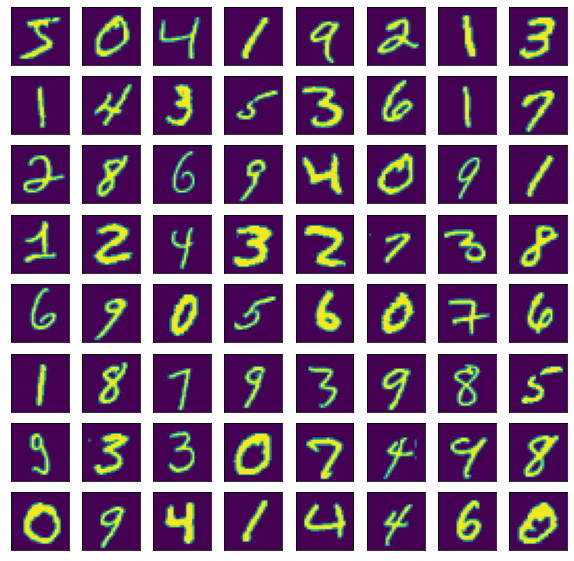

In [3]:
# check the data from the data loader
import matplotlib.pyplot as plt
import numpy as np

for X, y in train_dataloader:
    print(f'Shape of X [batch_size, channel, height, width]: {X.shape} ({X.dtype})') 
    print(f'Shape of y: {y.shape} ({y.dtype})')
    
    X = X.permute(dims=(0, 2, 3, 1)) # permute dimensions of the digit tensor to plot
    figs, axs = plt.subplots(nrows=8, ncols=8, squeeze=False, figsize=(10, 10))
    for idx, img in enumerate(X):
        ax = axs[idx//8, idx%8] # set the position of the digit tensor
        ax.imshow(np.asarray(img)) # convert the digit tensor to numpy ndarray and show it
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # unset ticks of the image 'img'
    break

---

### Define an MLP model and its forward propagation

We define **the architecture** of an MLP model and **its forward propagation** for layers.

The model consists of **the input layer** with **flattening operation**, **2 hidden layers**, and **the output layer**. It contains **biases** for each layer and the activation function as **the sigmoid function**.

And we define **the propagation of features** from the input layer to the output layer.

<center>
    <img src='figures/mlp.png' width='500px' height='250px' title='MLP' alt='mlp.png' />
</center>

<center>
    <img src='figures/sigmoid.png' width='300px' height='150px' title='Sigmoid function' alt='sigmoid.png' />
</center>

In [4]:
# import PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# define a MLP model with two hidden layers
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() # flatten some dimensions of the input tensor to one dimension
                                    # ex. ((batch_size,) channel, 28, 28) -> ((batch_size,) 784)
        self.input_layer = nn.Linear(28*28, 512) # it is also called as a fully connected layer
                                                 # all input neurons are connected with all output neurons
        self.hidden_layer = nn.Linear(512, 256)
        self.output_layer = nn.Linear(256, 10)
        self.act_fn = nn.Sigmoid() # call sigmoid() as the activation function
    
    def forward(self, x):
        x = self.flatten(x)
        h = self.act_fn(self.input_layer(x))
        h = self.act_fn(self.hidden_layer(h))
        y = self.output_layer(h) 
        return y

---

### Check device for training and load the model on the device

We got the datasets and the data loaders and defined our MLP model as the above.

To train the model under the data flow efficiently, we will use the **parallel computing of GPU**.

We check that **CUDA(GPU) is available** and set **the device as CUDA**.

In [5]:
# import cuda in PyTorch
import torch.cuda as cuda

# check device for training
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [6]:
# call the MLP model and send it to the device
myMLP = MLP().to(device) # the parameters and intermediate tensors will be on CUDA
print(myMLP)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (input_layer): Linear(in_features=784, out_features=512, bias=True)
  (hidden_layer): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (act_fn): Sigmoid()
)


---

### Specify the loss function and the optimizer for training

We call the **cross entropy loss function** and **SGD optimizer** with specific learning rate, to train the model for **multi-class classfication**.

**'Mean' reducing operation** of the cross entropy loss **average the batch losses**.

<img src='figures/loss.png' width='400px' height='200px' title='loss' alt='loss.png'></img>

<img src='figures/sgd.png' width='400px' height='200px' title='sgd' alt='sgd.png'></img>

In [7]:
# specify the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss(reduction='mean') # cross entropy loss function for classification
optimizer = torch.optim.SGD(myMLP.parameters(), lr=5e-3) # stochastic gradient descent with learning rate of 0.005

print(loss_fn)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0
    nesterov: False
    weight_decay: 0
)


---

### Iterate training loops of the model

Now, let's see the code of the training phase.

1. Set **the number of the epoch**  
The epoch means the number of times to **train all training data**.  
We choose the number as **the iterating number of the 1st for loops** as shown in the code.

2. Set the model in **train mode** (<code>train()</code>)  
The method makes the model's parameters **trainable** (the parameters can be updated.)

3. Send **the input data** to the device (**CUDA**)  
All of parameters, features, and the input data should be **computed by the same device** in the training phase.

4. Get **predictions** from forward pass, and compute **their loss**  
<code>myMLP(X)</code> **propagates the input data** through <code>forward()</code> of the model and **outputs predictions**,  
and then we compute **the mean loss of predictions** with the loss function <code>loss_fn(prediction, y)</code>

5. **Propagates backwards** the loss and **update** the parameters  
Before the back propagation, we should **clear the previous gradient** of the optimizer with <code>zero_grad()</code>.  
Then, we **compute the gradients of the loss** with respect to the parameters with <code>backward()</code>.  
Based on the gradients, we **update the parameters once** with calling <code>step()</code> of the optimizer.

6. **Repeat 2.~5.** during epochs

<center>
        <img src='figures/forward.png' width='400px' height='200px' title='Forward pass' alt='forward.png'></img>
</center>

<center>
        <img src='figures/backward.png' width='400px' height='200px' title='Backward propagation' alt='backward.png'></img>
</center>

In [8]:
# train the MLP model
epochs = 5
ndata = len(train_dataloader.dataset) 
print('training starts!')

for e in range(epochs):
    print(f'\nepoch {e+1}\n------------------------------')
    myMLP.train() # train mode
    
    for b, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device) # input and target to device(gpu)

        prediction = myMLP(X) # forward pass
        train_loss = loss_fn(prediction, y) # calculate the loss 

        optimizer.zero_grad() # clear gradients
        train_loss.backward() # backpropagation
        optimizer.step() # update the parameters

        if b % 100 == 0 and e < 5: # track the training
            train_loss, current = train_loss.item(), b * len(X) 
            print(f'loss: {train_loss:>7f}  [{current:>5d}/{ndata:>5d}]')
print('\ntraining is finished!')

training starts!

epoch 1
------------------------------
loss: 2.362254  [    0/60000]
loss: 2.296890  [ 6400/60000]
loss: 2.312061  [12800/60000]
loss: 2.303455  [19200/60000]
loss: 2.307940  [25600/60000]
loss: 2.306019  [32000/60000]
loss: 2.295276  [38400/60000]
loss: 2.307863  [44800/60000]
loss: 2.301445  [51200/60000]
loss: 2.289589  [57600/60000]

epoch 2
------------------------------
loss: 2.297217  [    0/60000]
loss: 2.292630  [ 6400/60000]
loss: 2.308006  [12800/60000]
loss: 2.298636  [19200/60000]
loss: 2.303485  [25600/60000]
loss: 2.301361  [32000/60000]
loss: 2.290095  [38400/60000]
loss: 2.304058  [44800/60000]
loss: 2.296885  [51200/60000]
loss: 2.284763  [57600/60000]

epoch 3
------------------------------
loss: 2.292457  [    0/60000]
loss: 2.287471  [ 6400/60000]
loss: 2.303523  [12800/60000]
loss: 2.293339  [19200/60000]
loss: 2.298605  [25600/60000]
loss: 2.296159  [32000/60000]
loss: 2.284225  [38400/60000]
loss: 2.299747  [44800/60000]
loss: 2.291704  [51200/

---

### Test the performance of the model

After the training phase, we check how the model can classify the handwritten digits well.

We test the model with **the testing set**, which consists of **excluded data from the training set**.

We compute **the mean loss** about all data and **the accuracy** of correct predictions

In [9]:
# test the MLP model
ndata = len(test_dataloader.dataset)
nbatch = len(test_dataloader)
myMLP.eval() # test mode
test_loss, test_correction = 0, 0 # initialize

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        prediction = myMLP(X)
        test_loss += loss_fn(prediction, y).item() # add up the loss
        test_correction += (prediction.argmax(1) == y).type(torch.float).sum().item() # add up the correct predictions
test_loss /= nbatch # mean loss
test_correction /= ndata # accuracy for all data
print(f"test error\n-> accuracy: {(100*test_correction):>0.1f}%, average loss: {test_loss:>8f}")

test error
-> accuracy: 28.1%, average loss: 2.270540
